#Binary AskQE Extension  
Pipeline: SRL / OpenIE / Dependency /NER

#Git

In [51]:
!git config --global user.email "erfan.alerom@gmail.com"
!git config --global user.name "erythm"

In [ ]:
!cp '/content/drive/MyDrive/Colab Notebooks/extention.ipynb' /content/askqe/

In [ ]:
!git add extention.ipynb

In [ ]:
!git commit -m "Implement hybrid binary QA extension with improved metrics"

[main acab19d] Implement hybrid binary QA extension with improved metrics
 1 file changed, 1 insertion(+), 1 deletion(-)


In [ ]:
!git remote set-url origin https://@github.com/erythm/askqe.git
!git push origin main

Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 313.64 KiB | 6.67 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/erythm/askqe.git
   e611acf..acab19d  main -> main


In [ ]:
!git reset --soft HEAD~1

# Requirments

In [1]:
!git clone https://github.com/erythm/askqe.git

Cloning into 'askqe'...
remote: Enumerating objects: 1148, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 1148 (delta 21), reused 20 (delta 8), pack-reused 1102 (from 2)
Receiving objects: 100% (1148/1148), 53.70 MiB | 13.17 MiB/s, done.
Resolving deltas: 100% (893/893), done.
Updating files: 100% (1044/1044), done.


In [ ]:
%cd askqe

/content/askqe


In [ ]:
%cd ..

/content


In [2]:
!pip install -q vllm transformers accelerate sacrebleu
!pip install -q spacy
!python -m spacy download en_core_web_sm

print("Libraries installed!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.9/474.9 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.0/355.0 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.0/183.0 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 128.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB

In [3]:
import json
import os
import re
import ast
import pandas as pd
import numpy as np
from scipy.stats import kendalltau, spearmanr, pearsonr
from tqdm import tqdm

print("Imports done!")

Imports done!


#Repository Imports

In [6]:
import sys
import importlib.util

REPO_PATH = "askqe"

# Add repository paths to Python path
sys.path.insert(0, REPO_PATH)
sys.path.insert(0, f"{REPO_PATH}/QG/code")
sys.path.insert(0, f"{REPO_PATH}/QA/code")
sys.path.insert(0, f"{REPO_PATH}/biomqm/askqe")
sys.path.insert(0, f"{REPO_PATH}/evaluation/string-comparison")

# --- Import Prompts from Repository ---
from QG.code.prompt import nli as qg_nli_prompt
from QG.code.prompt import vanilla as qg_vanilla_prompt
from QA.code.prompt import qa_prompt
from biomqm.askqe.prompt import atomic_fact_prompt

# --- Import utils using importlib ---
utils_path = f"{REPO_PATH}/evaluation/string-comparison/utils.py"
spec = importlib.util.spec_from_file_location("utils_module", utils_path)
utils_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(utils_module)

# Assign scoring functions (for comparison with baseline)
repo_f1_score = utils_module.f1_score
repo_exact_match_score = utils_module.exact_match_score
normalize_answer = utils_module.normalize_answer

print("Repository imports loaded!")
print(f"   - Prompts: atomic_fact_prompt, qg_nli_prompt, qa_prompt")
print(f"   - Scoring: f1_score, exact_match_score")

# Store templates
atomic_fact_prompt_template = atomic_fact_prompt
qg_prompt_template = qg_nli_prompt
qa_prompt_template = qa_prompt

Repository imports loaded!
   - Prompts: atomic_fact_prompt, qg_nli_prompt, qa_prompt
   - Scoring: f1_score, exact_match_score


# Load Qwen2.5-7B Model with vLLM

In [7]:
from vllm import LLM, SamplingParams

MODEL_ID = "Qwen/Qwen2.5-7B-Instruct-AWQ"

print(f"Loading {MODEL_ID}...")

llm = LLM(
    model=MODEL_ID,
    quantization="awq",
    dtype="half",
    max_model_len=2048,
    gpu_memory_utilization=0.80,
    seed=42,
    enable_prefix_caching=True,
    disable_log_stats=True,
)

SAMPLING_PARAMS = SamplingParams(
    temperature=0,
    max_tokens=1024,
)

print(f"LLM loaded: {MODEL_ID}")

Loading Qwen/Qwen2.5-7B-Instruct-AWQ...
INFO 12-29 12:54:33 [utils.py:253] non-default args: {'dtype': 'half', 'seed': 42, 'max_model_len': 2048, 'enable_prefix_caching': True, 'gpu_memory_utilization': 0.8, 'disable_log_stats': True, 'quantization': 'awq', 'model': 'Qwen/Qwen2.5-7B-Instruct-AWQ'}


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

INFO 12-29 12:54:53 [model.py:514] Resolved architecture: Qwen2ForCausalLM
INFO 12-29 12:54:53 [model.py:1661] Using max model len 2048
INFO 12-29 12:54:57 [scheduler.py:230] Chunked prefill is enabled with max_num_batched_tokens=8192.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Parse safetensors files:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

WARNING 12-29 12:55:02 [system_utils.py:136] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reasons: CUDA is initialized
INFO 12-29 13:01:11 [llm.py:360] Supported tasks: ['generate']
LLM loaded: Qwen/Qwen2.5-7B-Instruct-AWQ


#Helper functions

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)


def generate_text_batch(prompts, sampling_params=SAMPLING_PARAMS):
    """Generate text for multiple prompts using chat template."""
    formatted_prompts = []
    for p in prompts:
        messages = [{"role": "user", "content": p}]
        formatted = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        formatted_prompts.append(formatted)

    outputs = llm.generate(formatted_prompts, sampling_params)

    generated_texts = []
    for output in outputs:
        text = output.outputs[0].text.strip()
        generated_texts.append(text)

    return generated_texts


def parse_list_output(text):
    """Parse a string representation of a list into a Python list."""
    try:
        # Clean up
        text = text.strip()

        # Find list boundaries
        start = text.find('[')
        end = text.rfind(']') + 1

        if start != -1 and end > start:
            candidate = text[start:end]
            return ast.literal_eval(candidate)
        return []
    except:
        return []


# Test
test_output = generate_text_batch(["Say 'Hello World' and nothing else."])
print(f"Test output: {test_output[0]}")
print("LLM helper functions ready!")

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Test output: Hello World
LLM helper functions ready!


#Load data

In [9]:
LIMIT = None  # None = all data


# MQM Score Calculation
def calculate_mqm_score(errors):
    """Calculate MQM score from errors list.
    Formula: 100 - (Minor*1 + Major*5 + Critical*25)
    """
    weights = {"Minor": 1, "Major": 5, "Critical": 25}
    score_penalty = 0
    for error in errors:
        severity = error.get("severity")
        score_penalty += weights.get(severity, 0)
    return max(0, 100 - score_penalty)


def get_max_severity(errors):
    """Get maximum severity from errors list."""
    if not errors:
        return "No Error"
    severities = [e.get("severity") for e in errors if e]
    if "Critical" in severities:
        return "Critical"
    if "Major" in severities:
        return "Major"
    if "Minor" in severities:
        return "Minor"
    return "No Error"



# Load BIOMQM Data
def load_biomqm_data(file_path, limit=None):
    """Load BIOMQM dataset - same structure as baseline."""
    data_entries = []

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                if limit and i >= limit:
                    break
                item = json.loads(line)

                entry = {
                    'id': item.get('doc_id', f'doc_{i}'),
                    'source': item['src'],
                    'target': item['tgt'],  # German translation
                    'backtranslation': item.get('bt_tgt', ''),
                    'errors': item.get('errors_tgt', []),
                    'mqm_score': calculate_mqm_score(item.get('errors_tgt', [])),
                    'severity': get_max_severity(item.get('errors_tgt', []))
                }
                data_entries.append(entry)

        print(f"✅ Loaded {len(data_entries)} entries from BIOMQM")
        return data_entries

    except FileNotFoundError:
        print(f"❌ Error: File {file_path} not found.")
        return []

##Data Cleaning

In [10]:
def term_in_data(dataset):
    """Remove rows where error term is not in source/target.
    This cleans invalid error annotations.
    """
    valid_rows = []
    removed_count = 0

    for row in dataset:
        tgt = row.get('target', '')
        src = row.get('source', '')
        errors = row.get('errors', [])
        is_row_clean = True

        for error in errors:
            term = error.get('term', '')
            if term:
                # Check if error term exists in source or target
                if term not in tgt and term not in src:
                    is_row_clean = False
                    break

        if is_row_clean:
            valid_rows.append(row)
        else:
            removed_count += 1

    print(f"   Removed {removed_count} rows with invalid error terms")
    return valid_rows

# LOAD AND CLEAN DATA
BIOMQM_FILE = f"{REPO_PATH}/biomqm/dev_with_backtranslation.jsonl"

print("📂 Loading BIOMQM dataset...")
dataset_raw = load_biomqm_data(BIOMQM_FILE, limit=LIMIT)

print("\nCleaning data...")
dataset = term_in_data(dataset_raw)
print(f"Clean dataset: {len(dataset)} samples")

📂 Loading BIOMQM dataset...
✅ Loaded 5216 entries from BIOMQM

Cleaning data...
   Removed 216 rows with invalid error terms
Clean dataset: 5000 samples


##STATISTICS

In [11]:
df_preview = pd.DataFrame(dataset)

print(f"\n" + "="*50)
print("📊 DATASET STATISTICS")
print("="*50)

print(f"\n📊 Severity Distribution:")
print(df_preview["severity"].value_counts().to_string())

print(f"\n📊 MQM Score Statistics:")
print(f"   Min: {df_preview['mqm_score'].min()}")
print(f"   Max: {df_preview['mqm_score'].max()}")
print(f"   Mean: {df_preview['mqm_score'].mean():.2f}")

print(f"\n📊 MQM Score by Severity:")
for sev in ["No Error", "Minor", "Major", "Critical"]:
    sev_data = df_preview[df_preview["severity"] == sev]["mqm_score"]
    if len(sev_data) > 0:
        print(f"   {sev:12s}: mean={sev_data.mean():.1f}, count={len(sev_data)}")

# Example
print(f"\n Example Entry:")
ex = dataset[0]
print(f"   ID: {ex['id']}")
print(f"   Source: {ex['source'][:70]}...")
print(f"   Target: {ex['target'][:70]}...")
print(f"   BT: {ex['backtranslation'][:70]}...")
print(f"   Severity: {ex['severity']}")
print(f"   MQM Score: {ex['mqm_score']}")
print(f"   Errors: {ex['errors'][:2] if ex['errors'] else 'None'}...")


📊 DATASET STATISTICS

📊 Severity Distribution:
severity
No Error    2037
Minor       1803
Major       1049
Critical     111

📊 MQM Score Statistics:
   Min: 23
   Max: 100
   Mean: 96.85

📊 MQM Score by Severity:
   No Error    : mean=100.0, count=2037
   Minor       : mean=98.4, count=1803
   Major       : mean=90.9, count=1049
   Critical    : mean=70.5, count=111

 Example Entry:
   ID: doc11
   Source: Three cases of cervicofacial NF are presented in this case report....
   Target: In diesem Fallbericht werden drei Fälle von zervikofazialem NF vorgest...
   BT: This case report presents three cases of cervicofacial NF....
   Severity: Major
   MQM Score: 95
   Errors: [{'term': 'zervikofazialem', 'startIndex': 44, 'endIndex': 58, 'error_category': 'Linguistic_conventions', 'error_subcategory': 'Grammar', 'severity': 'Major'}]...


#Feature Extraction

##Load spaCy

In [12]:
import spacy

nlp = spacy.load("en_core_web_sm")

print("spaCy loaded!")

spaCy loaded!


##spaCy Feature Extraction
Negations, Numbers, Dates, Entities, Verbs

In [13]:
def extract_negations(doc):
    """Extract negations with their scope."""
    negations = []
    for token in doc:
        if token.dep_ == "neg":
            head = token.head
            negations.append({
                "negation": token.text,
                "negated_word": head.lemma_,
                "verb": head.text
            })
    return negations


def extract_numbers(doc):
    """Extract numbers with context."""
    numbers = []
    seen = set()

    for token in doc:
        if token.pos_ == "NUM":
            value = token.text.strip()
            context = None

            if token.dep_ == "nummod" and token.head.pos_ in ("NOUN", "PROPN"):
                context = token.head.text
            elif token.head.pos_ in ("NOUN", "PROPN"):
                context = token.head.text
            else:
                for child in token.head.children:
                    if child.pos_ in ("NOUN", "PROPN"):
                        context = child.text
                        break

            key = (value, context)
            if key not in seen and value:
                seen.add(key)
                numbers.append({"value": value, "context": context})

    return numbers


def extract_dates(doc):
    """Extract date/time/quantity entities."""
    dates = []
    seen = set()

    for ent in doc.ents:
        if ent.label_ in ("DATE", "TIME", "PERCENT", "MONEY", "QUANTITY", "CARDINAL", "ORDINAL"):
            if ent.text not in seen:
                seen.add(ent.text)
                dates.append({"text": ent.text, "label": ent.label_})

    return dates


def extract_entities(doc):
    """Extract important named entities."""
    entities = []
    seen = set()
    important_labels = {"PERSON", "ORG", "GPE", "PRODUCT", "EVENT", "WORK_OF_ART", "LAW"}

    for ent in doc.ents:
        if ent.label_ in important_labels:
            if ent.text.lower() not in seen and len(ent.text) > 2:
                seen.add(ent.text.lower())
                entities.append({"text": ent.text, "label": ent.label_})

    return entities


def extract_main_verbs(doc):
    """Extract main verbs with subject/object."""
    verbs = []

    for token in doc:
        if token.pos_ == "VERB" and token.dep_ in ("ROOT", "relcl", "advcl"):
            verb_info = {
                "verb": token.lemma_,
                "verb_text": token.text,
                "subject": None,
                "object": None
            }

            for child in token.children:
                if child.dep_ in ("nsubj", "nsubjpass"):
                    subj_tokens = [t.text for t in child.subtree]
                    if len(subj_tokens) <= 5:
                        verb_info["subject"] = " ".join(subj_tokens)

                elif child.dep_ in ("dobj", "obj", "attr"):
                    obj_tokens = [t.text for t in child.subtree]
                    if len(obj_tokens) <= 5:
                        verb_info["object"] = " ".join(obj_tokens)

            if verb_info["subject"] or verb_info["object"]:
                verbs.append(verb_info)

    return verbs


def extract_spacy_features(text):
    """Extract all spaCy-based features from text."""
    doc = nlp(text)
    return {
        "negations": extract_negations(doc),
        "numbers": extract_numbers(doc),
        "dates": extract_dates(doc),
        "entities": extract_entities(doc),
        "verbs": extract_main_verbs(doc)
    }


# Test
test_text = "Dr. Smith did not give the patient 5mg of morphine on Monday."
features = extract_spacy_features(test_text)
print(f"Text: {test_text}")
print(f"   Negations: {features['negations']}")
print(f"   Numbers: {features['numbers']}")
print(f"   Dates: {features['dates']}")
print(f"   Entities: {features['entities']}")
print(f"   Verbs: {features['verbs']}")
print("spaCy feature extraction ready!")

Text: Dr. Smith did not give the patient 5mg of morphine on Monday.
   Negations: [{'negation': 'not', 'negated_word': 'give', 'verb': 'give'}]
   Numbers: [{'value': '5', 'context': 'mg'}]
   Dates: [{'text': '5', 'label': 'CARDINAL'}, {'text': 'Monday', 'label': 'DATE'}]
   Entities: [{'text': 'Smith', 'label': 'PERSON'}]
   Verbs: [{'verb': 'give', 'verb_text': 'give', 'subject': 'Dr. Smith', 'object': None}]
spaCy feature extraction ready!


##LLM-based SRL (Semantic Role Labeling)
agent, patient, time, location, negation

In [14]:
SRL_PROMPT = """Extract semantic roles from this sentence. Return ONLY a JSON object.

Sentence: "{sentence}"

Extract:
- verb: main action verb
- agent: who performs the action (ARG0)
- patient: what/who is affected (ARG1)
- time: when (if mentioned)
- location: where (if mentioned)
- negated: true/false (is the action negated?)

Return format:
{{"verb": "...", "agent": "...", "patient": "...", "time": "...", "location": "...", "negated": true/false}}

If any role is not present, use null. Return ONLY the JSON, no explanation."""


def extract_srl_batch(sentences):
    """Extract SRL using LLM for multiple sentences (batched)."""
    if not sentences:
        return []

    prompts = [SRL_PROMPT.format(sentence=s) for s in sentences]
    outputs = generate_text_batch(prompts)

    results = []
    for output in outputs:
        try:
            json_match = re.search(r'\{[^}]+\}', output, re.DOTALL)
            if json_match:
                srl = json.loads(json_match.group())
                results.append(srl)
            else:
                results.append({})
        except:
            results.append({})

    return results


# Test
test_sentences = [
    "The doctor gave the patient 5mg of morphine.",
    "The patient was not given antibiotics by Dr. Smith.",
    "Three cases are presented in this report."
]

print("LLM-based SRL Test:")
srl_results = extract_srl_batch(test_sentences)

for sent, srl in zip(test_sentences, srl_results):
    print(f"\n📝 Text: {sent}")
    print(f"   SRL: {srl}")

print("\nSRL extraction ready!")

LLM-based SRL Test:


Adding requests:   0%|          | 0/3 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/3 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


📝 Text: The doctor gave the patient 5mg of morphine.
   SRL: {'verb': 'gave', 'agent': 'The doctor', 'patient': 'the patient', 'time': None, 'location': None, 'negated': False}

📝 Text: The patient was not given antibiotics by Dr. Smith.
   SRL: {'verb': 'given', 'agent': 'Dr. Smith', 'patient': 'The patient', 'time': None, 'location': None, 'negated': True}

📝 Text: Three cases are presented in this report.
   SRL: {'verb': 'presented', 'agent': None, 'patient': 'Three cases', 'time': None, 'location': None, 'negated': False}

SRL extraction ready!


##OpenIE Triples
Extracts (subject, relation, object) triples


In [15]:
def extract_openie_triples(doc):
    """Extract OpenIE-style triples: (subject, relation, object)."""
    triples = []

    for token in doc:
        if token.pos_ == "VERB":
            subject = None
            obj = None
            relation = token.text

            # Get auxiliaries for full relation
            aux_parts = []
            for child in token.children:
                if child.dep_ in ("aux", "auxpass"):
                    aux_parts.append(child.text)

            if aux_parts:
                relation = " ".join(aux_parts) + " " + token.text

            # Find subject
            for child in token.children:
                if child.dep_ in ("nsubj", "nsubjpass"):
                    subject = " ".join([t.text for t in child.subtree])
                    break

            # Find object
            for child in token.children:
                if child.dep_ in ("dobj", "obj", "attr", "pobj", "oprd"):
                    obj = " ".join([t.text for t in child.subtree])
                    break

            # Check for prepositional objects
            if not obj:
                for child in token.children:
                    if child.dep_ == "prep":
                        for grandchild in child.children:
                            if grandchild.dep_ == "pobj":
                                obj = child.text + " " + " ".join([t.text for t in grandchild.subtree])
                                break

            if subject and obj:
                triples.append({
                    "subject": subject.strip(),
                    "relation": relation.strip(),
                    "object": obj.strip()
                })

    return triples


# Test
test_sentences = [
    "The doctor gave the patient morphine.",
    "Three cases of NF are presented in this report.",
    "COVID-19 affects the respiratory system."
]

print("OpenIE Test:")
for sent in test_sentences:
    doc = nlp(sent)
    triples = extract_openie_triples(doc)
    print(f"\n📝 Text: {sent}")
    if triples:
        for t in triples:
            print(f"   → ({t['subject']}, {t['relation']}, {t['object']})")
    else:
        print("   → No triples found")

print("\n OpenIE extraction ready!")

OpenIE Test:

📝 Text: The doctor gave the patient morphine.
   → (The doctor, gave, the patient morphine)

📝 Text: Three cases of NF are presented in this report.
   → (Three cases of NF, are presented, in this report)

📝 Text: COVID-19 affects the respiratory system.
   → (COVID-19, affects, the respiratory system)

 OpenIE extraction ready!


##Dependency Parsing - Modifiers
negation scope, adjectives, adverbs

In [16]:
def extract_negations_with_scope(doc):
    """Extract negations with their full scope."""
    negations = []

    for token in doc:
        if token.dep_ == "neg":
            head = token.head
            scope = " ".join([t.text for t in head.subtree])

            # Limit scope length
            scope_tokens = scope.split()
            if len(scope_tokens) > 10:
                scope = " ".join(scope_tokens[:10]) + "..."

            negations.append({
                "negation": token.text,
                "negated_word": head.lemma_,
                "verb": head.text,
                "scope": scope
            })

    return negations


def extract_modifiers(doc):
    """Extract important modifiers (adjectives and adverbs)."""
    modifiers = []
    skip_adverbs = {"also", "just", "only", "even", "still"}

    for token in doc:
        # Adjectives modifying nouns
        if token.pos_ == "ADJ" and token.dep_ in ("amod", "attr"):
            modifiers.append({
                "modifier": token.text,
                "type": "adjective",
                "modifies": token.head.text,
                "full_phrase": " ".join([t.text for t in token.head.subtree])
            })

        # Adverbs modifying verbs
        elif token.pos_ == "ADV" and token.dep_ == "advmod":
            if token.text.lower() not in skip_adverbs:
                modifiers.append({
                    "modifier": token.text,
                    "type": "adverb",
                    "modifies": token.head.text
                })

    return modifiers


# Test
test_sentences = [
    "The patient was not given antibiotics.",
    "The highly effective treatment was used.",
    "The virus is extremely contagious."
]

print(" Dependency Parsing Test:")
for sent in test_sentences:
    doc = nlp(sent)
    negs = extract_negations_with_scope(doc)
    mods = extract_modifiers(doc)

    print(f"\n📝 Text: {sent}")
    print(f"   Negations: {negs}")
    print(f"   Modifiers: {mods}")

print("\n Dependency parsing ready!")

 Dependency Parsing Test:

📝 Text: The patient was not given antibiotics.
   Negations: [{'negation': 'not', 'negated_word': 'give', 'verb': 'given', 'scope': 'The patient was not given antibiotics .'}]
   Modifiers: []

📝 Text: The highly effective treatment was used.
   Negations: []
   Modifiers: [{'modifier': 'highly', 'type': 'adverb', 'modifies': 'effective'}, {'modifier': 'effective', 'type': 'adjective', 'modifies': 'treatment', 'full_phrase': 'The highly effective treatment'}]

📝 Text: The virus is extremely contagious.
   Negations: []
   Modifiers: [{'modifier': 'extremely', 'type': 'adverb', 'modifies': 'contagious'}]

 Dependency parsing ready!


##Combined Feature Extraction

In [17]:
def extract_all_features(text):
    """
    Master function: Extract ALL features from text.
    Combines: spaCy features + OpenIE + Modifiers
    """
    doc = nlp(text)

    return {
        # From spaCy basics
        "negations": extract_negations(doc),
        "numbers": extract_numbers(doc),
        "dates": extract_dates(doc),
        "entities": extract_entities(doc),
        "verbs": extract_main_verbs(doc),

        # From OpenIE
        "openie_triples": extract_openie_triples(doc),

        # From Modifiers
        "modifiers": extract_modifiers(doc),
    }


# Test
test_text = "The patient was not given 5mg of morphine by Dr. Smith."
features = extract_all_features(test_text)

print(f"📝 Text: {test_text}")
print(f"\n All Features:")
for key, value in features.items():
    if value:
        print(f"   {key}: {value}")

print("\n Combined feature extraction ready!")

📝 Text: The patient was not given 5mg of morphine by Dr. Smith.

 All Features:
   negations: [{'negation': 'not', 'negated_word': 'give', 'verb': 'given'}]
   numbers: [{'value': '5', 'context': 'mg'}]
   dates: [{'text': '5', 'label': 'CARDINAL'}]
   entities: [{'text': 'Smith', 'label': 'PERSON'}]
   verbs: [{'verb': 'give', 'verb_text': 'given', 'subject': 'The patient', 'object': '5 mg of morphine'}]
   openie_triples: [{'subject': 'The patient', 'relation': 'was given', 'object': '5 mg of morphine'}]

 Combined feature extraction ready!


##Template Question Generation (Yes/No)

In [19]:
SKIP_WORDS = {"this", "that", "it", "they", "these", "those", "which", "what", "who", "there", "here"}

def generate_template_questions(features):
    """Generate Yes/No questions from extracted features."""
    questions = []
    seen = set()

    def add_q(q, key=None):
        k = key or q["question"].lower()
        if k not in seen:
            seen.add(k)
            questions.append(q)

    # 1. NEGATION questions (weight 3.0) - Critical!
    for neg in features.get("negations", []):
        verb = neg.get("verb", "")
        if verb:
            add_q({
                "question": f"Is the action '{verb}' negated in the text?",
                "type": "negation",
                "weight": 3.0
            })

    # 2. NUMBER questions (weight 3.0) - Critical!
    for num in features.get("numbers", []):
        value = num.get("value", "")
        context = num.get("context", "")

        if value and context and context not in ("CARDINAL", "ORDINAL", "DATE", "TIME"):
            add_q({
                "question": f"Does the text mention '{value} {context}'?",
                "type": "number",
                "weight": 3.0
            })
        elif value:
            add_q({
                "question": f"Does the text mention the number '{value}'?",
                "type": "number",
                "weight": 3.0
            })

    # 3. DATE/TIME questions (weight 2.5)
    for date in features.get("dates", []):
        text = date.get("text", "")
        if text and text.lower() not in SKIP_WORDS and len(text) > 1:
            add_q({
                "question": f"Does the text mention '{text}'?",
                "type": "date",
                "weight": 2.5
            })

    # 4. ENTITY questions (weight 2.0)
    for ent in features.get("entities", []):
        text = ent.get("text", "")
        if text and text.lower() not in SKIP_WORDS:
            add_q({
                "question": f"Is '{text}' mentioned in the text?",
                "type": "entity",
                "weight": 2.0
            })

    # 5. VERB/ACTION questions (weight 1.5)
    skip_verbs = {"be", "have", "do", "make", "get", "go", "take", "give", "say"}
    for verb_info in features.get("verbs", []):
        verb = verb_info.get("verb", "")
        subject = verb_info.get("subject", "")
        obj = verb_info.get("object", "")

        if verb.lower() in skip_verbs:
            continue
        if subject and subject.split()[0].lower() in SKIP_WORDS:
            continue

        if subject and obj:
            add_q({
                "question": f"Does '{subject}' {verb} '{obj}'?",
                "type": "verb",
                "weight": 1.5
            })
        elif subject and verb:
            add_q({
                "question": f"Does '{subject}' {verb}?",
                "type": "verb",
                "weight": 1.5
            })

    # 6. OpenIE TRIPLE questions (weight 1.5)
    for triple in features.get("openie_triples", []):
        subj = triple.get("subject", "")
        rel = triple.get("relation", "")
        obj = triple.get("object", "")

        if subj and rel and obj:
            if subj.split()[0].lower() not in SKIP_WORDS:
                add_q({
                    "question": f"Is it true that '{subj}' {rel} '{obj}'?",
                    "type": "openie",
                    "weight": 1.5
                })

    return questions


# Test
test_text = "Dr. Smith did not give the patient 5mg of morphine on Monday."
features = extract_all_features(test_text)
template_qs = generate_template_questions(features)

print(f"📝 Text: {test_text}")
print(f"\n❓ Template Questions ({len(template_qs)}):")
for q in template_qs:
    print(f"   [{q['type']}, w={q['weight']}] {q['question']}")

print("\nTemplate question generation ready!")

📝 Text: Dr. Smith did not give the patient 5mg of morphine on Monday.

❓ Template Questions (5):
   [negation, w=3.0] Is the action 'give' negated in the text?
   [number, w=3.0] Does the text mention '5 mg'?
   [date, w=2.5] Does the text mention 'Monday'?
   [entity, w=2.0] Is 'Smith' mentioned in the text?
   [openie, w=1.5] Is it true that 'Dr. Smith' did give 'on Monday'?

Template question generation ready!


#LLM-based Question Generation

#Word Difference Questions
Questions based on word differences between Source and BT.
These questions directly catch errors.

In [46]:
def find_significant_differences(source, bt):
    """Find significant word differences (not just paraphrasing)."""
    # Tokenize
    src_words = set(re.findall(r'\b\w+\b', source.lower()))
    bt_words = set(re.findall(r'\b\w+\b', bt.lower()))

    only_in_src = src_words - bt_words
    only_in_bt = bt_words - src_words

    return only_in_src, only_in_bt


def generate_difference_questions(source, bt):
    """Generate questions about significant word differences."""
    questions = []

    # Extended skip words (common paraphrases)
    skip_words = {
        # Standard stop words
        'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
        'of', 'with', 'by', 'from', 'this', 'that', 'is', 'are', 'was', 'were',
        'be', 'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did',
        'will', 'would', 'could', 'should', 'may', 'might', 'must', 'can',
        'it', 'its', 'they', 'them', 'their', 'we', 'our', 'you', 'your',
        'i', 'me', 'my', 'he', 'she', 'his', 'her', 'as', 'if', 'then',
        'than', 'so', 'no', 'not', 'only', 'also', 'just', 'more', 'most',
        'other', 'into', 'over', 'such', 'these', 'those', 'each', 'all', 'any',
        # Common verbs (often paraphrased)
        'show', 'shows', 'showed', 'shown', 'present', 'presents', 'presented',
        'include', 'includes', 'included', 'contain', 'contains', 'contained',
        'use', 'uses', 'used', 'using', 'make', 'makes', 'made', 'making',
        'take', 'takes', 'took', 'taken', 'give', 'gives', 'gave', 'given',
        'get', 'gets', 'got', 'getting', 'find', 'finds', 'found', 'finding',
        'know', 'knows', 'knew', 'known', 'think', 'thinks', 'thought',
        'see', 'sees', 'saw', 'seen', 'come', 'comes', 'came', 'coming',
        'go', 'goes', 'went', 'gone', 'going', 'want', 'wants', 'wanted',
        'need', 'needs', 'needed', 'seem', 'seems', 'seemed',
        # Common adjectives/adverbs
        'well', 'good', 'better', 'best', 'new', 'old', 'first', 'last',
        'long', 'great', 'little', 'own', 'same', 'right', 'big', 'high',
        'different', 'small', 'large', 'next', 'early', 'young', 'important',
        # Articles and determiners
        'one', 'two', 'both', 'few', 'many', 'much', 'several', 'some',
        # Prepositions
        'about', 'after', 'before', 'between', 'through', 'during', 'without',
        'within', 'along', 'following', 'across', 'behind', 'beyond', 'under',
        # Conjunctions
        'however', 'therefore', 'although', 'because', 'since', 'while', 'whereas',
        # Common medical/academic words (often paraphrased)
        'study', 'studies', 'studied', 'case', 'cases', 'report', 'reports',
        'reported', 'patient', 'patients', 'result', 'results', 'method', 'methods',
        'analysis', 'data', 'group', 'groups', 'treatment', 'treatments',
        'approach', 'approaches', 'technique', 'techniques', 'procedure', 'procedures',
        # Connector words
        'regarding', 'concerning', 'respect', 'based', 'according', 'due',
    }

    only_in_src, only_in_bt = find_significant_differences(source, bt)

    # Filter and create questions
    for word in only_in_src:
        # Skip if too short, stopword, or just a number
        if len(word) <= 3 or word in skip_words or word.isdigit():
            continue
        # Skip common suffixes that indicate paraphrasing
        if any(word.endswith(suf) for suf in ['ly', 'ing', 'ed', 'er', 'est', 'tion', 'ment']):
            # Check if base word exists in BT
            base = word.rstrip('lyingederstion')
            if any(base in bt_word for bt_word in only_in_bt):
                continue

        questions.append({
            "question": f"Does the text contain the word '{word}'?",
            "type": "word_diff",
            "weight": 4.0,
        })

    for word in only_in_bt:
        if len(word) <= 3 or word in skip_words or word.isdigit():
            continue
        if any(word.endswith(suf) for suf in ['ly', 'ing', 'ed', 'er', 'est', 'tion', 'ment']):
            base = word.rstrip('lyingederstion')
            if any(base in src_word for src_word in only_in_src):
                continue

        questions.append({
            "question": f"Does the text contain the word '{word}'?",
            "type": "word_diff",
            "weight": 4.0,
        })

    return questions


# Test
print("Word Difference Questions Test (Improved):")
print("="*60)

test_cases = [
    # Should detect (real error)
    ("All consecutive pats. with cholangiolithiasis",
     "All consecutive patterns with cholangiolithiasis"),
    # Should NOT detect (paraphrasing)
    ("The patient was treated successfully.",
     "The patient received successful treatment."),
    # Should detect (number change)
    ("Five cases are presented.",
     "Three cases are presented."),
    # Should detect (negation)
    ("The patient was not given antibiotics.",
     "The patient was given antibiotics."),
]

for src, bt in test_cases:
    print(f"\nSource: {src}")
    print(f"BT: {bt}")
    diff_qs = generate_difference_questions(src, bt)
    if diff_qs:
        print(f"Questions ({len(diff_qs)}):")
        for q in diff_qs:
            print(f"  - {q['question']}")
    else:
        print("  No significant differences (paraphrasing OK)")

print("\n" + "="*60)
print("Word Difference Questions ready!")

Word Difference Questions Test (Improved):

Source: All consecutive pats. with cholangiolithiasis
BT: All consecutive patterns with cholangiolithiasis
Questions (2):
  - Does the text contain the word 'pats'?
  - Does the text contain the word 'patterns'?

Source: The patient was treated successfully.
BT: The patient received successful treatment.
Questions (2):
  - Does the text contain the word 'received'?
  - Does the text contain the word 'successful'?

Source: Five cases are presented.
BT: Three cases are presented.
Questions (2):
  - Does the text contain the word 'five'?
  - Does the text contain the word 'three'?

Source: The patient was not given antibiotics.
BT: The patient was given antibiotics.
  No significant differences (paraphrasing OK)

Word Difference Questions ready!


##Atomic Fact Extraction (LLM)
 Extracting atomic facts from the source using an LLM

In [23]:
ATOMIC_FACT_PROMPT = """Break down this sentence into simple, atomic facts.
Each fact should be a single, independent piece of information.

Sentence: "{sentence}"

Rules:
- Each fact should contain ONE piece of information only
- Break down complex sentences into multiple simple facts
- Include: WHO, WHAT, WHEN, WHERE, HOW MANY, etc. as separate facts
- Keep facts short and simple
- Do NOT repeat the original sentence as one fact

Example:
Sentence: "Dr. Smith gave the patient 5mg of morphine on Monday."
Facts:
- Dr. Smith gave medication to a patient
- The medication was morphine
- The dosage was 5mg
- This happened on Monday

Output ONLY a JSON list: ["Fact 1", "Fact 2", ...]

Facts:"""


def extract_atomic_facts_batch(sentences):
    """Extract atomic facts from sentences using LLM."""
    if not sentences:
        return []

    prompts = [ATOMIC_FACT_PROMPT.format(sentence=s) for s in sentences]
    outputs = generate_text_batch(prompts)

    all_facts = []
    for output in outputs:
        facts = parse_list_output(output)
        # Filter empty or too short facts
        facts = [f for f in facts if isinstance(f, str) and len(f.strip()) > 10]
        all_facts.append(facts if facts else [])

    return all_facts


# Test
test_sentences = [
    "The doctor gave the patient 5mg of morphine.",
    "Three cases of cervicofacial NF are presented in this case report.",
    "The treatment was not effective for the elderly patients."
]

print("Atomic Fact Extraction Test (Improved):")
extracted_facts = extract_atomic_facts_batch(test_sentences)

for sent, facts in zip(test_sentences, extracted_facts):
    print(f"\n📝 Source: {sent}")
    print(f"   Facts ({len(facts)}):")
    for f in facts:
        print(f"      - {f}")

print("\nAtomic fact extraction ready!")

Atomic Fact Extraction Test (Improved):


Adding requests:   0%|          | 0/3 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/3 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


📝 Source: The doctor gave the patient 5mg of morphine.
   Facts (4):
      - The doctor gave medication to a patient
      - The medication was morphine
      - The dosage was 5mg
      - This happened

📝 Source: Three cases of cervicofacial NF are presented in this case report.
   Facts (4):
      - Three cases
      - are presented
      - in this case report
      - cervicofacial NF

📝 Source: The treatment was not effective for the elderly patients.
   Facts (3):
      - The treatment existed
      - The treatment was ineffective
      - The patients were elderly

Atomic fact extraction ready!


##NLI Filtering(Skipped)
Filtering facts that contradict the source - removing contradictions

In [29]:
# from transformers import pipeline
# import torch

# # Load NLI model (same as baseline)
# NLI_MODEL_ID = "potsawee/deberta-v3-large-mnli"

# print(f"Loading NLI model: {NLI_MODEL_ID}...")
# nli_pipeline = pipeline(
#     "text-classification",
#     model=NLI_MODEL_ID,
#     device=0 if torch.cuda.is_available() else -1
# )
# print("NLI model loaded!")


# def filter_facts_with_nli(sources, facts_list, threshold=0.85):
#     """
#     Filter atomic facts using NLI entailment.
#     Removes facts that contradict the source.

#     Args:
#         sources: List of source sentences
#         facts_list: List of lists of atomic facts
#         threshold: Confidence threshold for contradiction (default: 0.85)

#     Returns:
#         Filtered facts list
#     """
#     # Prepare NLI pairs
#     nli_inputs = []
#     input_map = []  # Track (source_idx, fact_idx) for each input

#     for src_idx, (source, facts) in enumerate(zip(sources, facts_list)):
#         for fact_idx, fact in enumerate(facts):
#             nli_inputs.append({
#                 "text": source,
#                 "text_pair": fact
#             })
#             input_map.append((src_idx, fact_idx))

#     if not nli_inputs:
#         return facts_list

#     # Run NLI
#     print(f"   Running NLI on {len(nli_inputs)} fact-source pairs...")
#     nli_results = nli_pipeline(nli_inputs, batch_size=32, truncation=True, max_length=512)

#     # Filter based on results
#     filtered_facts = [[] for _ in facts_list]
#     kept = 0
#     removed = 0

#     for (src_idx, fact_idx), result in zip(input_map, nli_results):
#         fact = facts_list[src_idx][fact_idx]
#         label = result["label"].upper()
#         score = result["score"]

#         # LABEL_0 = CONTRADICTION, LABEL_1 = NEUTRAL, LABEL_2 = ENTAILMENT
#         # Keep if NOT a confident contradiction
#         is_contradiction = "LABEL_0" in label or "CONTRADICTION" in label

#         if is_contradiction and score >= threshold:
#             removed += 1
#         else:
#             filtered_facts[src_idx].append(fact)
#             kept += 1

#     print(f"   NLI Filtering: {kept} kept, {removed} removed")
#     return filtered_facts


# # Test
# test_sources = [
#     "The doctor gave the patient 5mg of morphine.",
#     "The patient was NOT given antibiotics.",
#     "Three cases are presented in this report."
# ]

# test_facts = [
#     ["The doctor gave medication", "The dosage was 5mg", "The medication was morphine"],
#     ["The patient received antibiotics", "Antibiotics were given"],  # These should be filtered!
#     ["Three cases are presented", "The report contains cases"]
# ]

# print("\nNLI Filtering Test:")
# print(f"   Before filtering: {sum(len(f) for f in test_facts)} total facts")

# filtered = filter_facts_with_nli(test_sources, test_facts)

# print(f"   After filtering: {sum(len(f) for f in filtered)} total facts")
# print("\n   Results:")
# for src, orig, filt in zip(test_sources, test_facts, filtered):
#     print(f"\n   Source: {src}")
#     print(f"   Original facts: {orig}")
#     print(f"   Filtered facts: {filt}")

# print("\nNLI filtering ready!")
# ============================================
# CELL 14.5: NLI Filtering (Skipped)
def filter_facts_with_nli(sources, facts_list, threshold=0.85):
    """NLI Filtering - Skipped due to GPU memory."""
    print(f"NLI Filtering skipped - returning {sum(len(f) for f in facts_list)} facts unchanged")
    return facts_list

print("NLI Filtering: Skipped (GPU memory limit)")

NLI Filtering: Skipped (GPU memory limit)


##Question Generation(llm)

In [25]:
ATOMIC_QG_PROMPT = """Convert each atomic fact into a simple Yes/No question.
The question should be answerable with "Yes" if the fact is true.
Make questions specific and precise.

Atomic facts:
{facts}

Rules:
- Each fact becomes exactly ONE question
- Questions must be answerable with Yes/No only
- Be specific about numbers, names, and details

Output ONLY a JSON list: ["Question 1?", "Question 2?"]

Questions:"""


def generate_atomic_questions_batch(atomic_facts_list):
    """Generate Yes/No questions from atomic facts using LLM."""
    prompts = []
    valid_indices = []

    for idx, facts in enumerate(atomic_facts_list):
        if facts and len(facts) > 0:
            facts_str = "\n".join([f"- {f}" for f in facts])
            prompt = ATOMIC_QG_PROMPT.format(facts=facts_str)
            prompts.append(prompt)
            valid_indices.append(idx)

    all_questions = [[] for _ in atomic_facts_list]

    if not prompts:
        return all_questions

    outputs = generate_text_batch(prompts)

    for idx, output in zip(valid_indices, outputs):
        questions = []
        try:
            output = output.strip()

            # Remove markdown code blocks
            if "```" in output:
                parts = output.split("```")
                for part in parts:
                    if "[" in part:
                        output = part.replace("json", "").replace("python", "").strip()
                        break

            # Parse JSON list
            if "[" in output and "]" in output:
                start = output.index("[")
                end = output.rindex("]") + 1
                parsed = json.loads(output[start:end])

                if isinstance(parsed, list):
                    for q in parsed:
                        if isinstance(q, str) and q.strip() and "?" in q:
                            questions.append({
                                "question": q.strip(),
                                "type": "atomic",
                                "weight": 2.0
                            })
        except:
            # Fallback: regex extraction
            matches = re.findall(r'"([^"]+\?)"', output)
            for m in matches:
                questions.append({
                    "question": m,
                    "type": "atomic",
                    "weight": 2.0
                })

        all_questions[idx] = questions

    return all_questions


# Test
test_facts = [
    ["The patient was administered morphine.", "The dosage was 5mg."],
    ["Three cases of NF are presented."],
    []
]

print("Atomic → Binary Questions Test:")
atomic_qs = generate_atomic_questions_batch(test_facts)

for i, (facts, qs) in enumerate(zip(test_facts, atomic_qs)):
    print(f"\n   Sample {i+1}: {len(facts)} facts → {len(qs)} questions")
    for q in qs:
        print(f"      [{q['type']}] {q['question']}")

print("\nAtomic question generation ready!")

Atomic → Binary Questions Test:


Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


   Sample 1: 2 facts → 2 questions
      [atomic] Was the patient administered morphine?
      [atomic] Was the dosage 5mg?

   Sample 2: 1 facts → 1 questions
      [atomic] Are there exactly three cases of NF presented?

   Sample 3: 0 facts → 0 questions

Atomic question generation ready!


##Merge Questions
Template + Atomic questions + Difference

In [47]:
def merge_all_questions(template_qs, diff_qs, atomic_qs):
    """Merge all question types, removing duplicates."""
    merged = []
    seen = set()

    def add_q(q):
        key = q["question"].lower().strip()
        # Check for duplicates
        for existing in seen:
            if key in existing or existing in key:
                return
        seen.add(key)
        merged.append(q)

    # Priority order: diff > template > atomic
    # (diff questions are most likely to catch errors)
    for q in diff_qs:
        add_q(q)

    for q in template_qs:
        add_q(q)

    for q in atomic_qs:
        add_q(q)

    return merged


# Test
test_template = [{"question": "Is 'ERCP' mentioned?", "type": "entity", "weight": 2.0}]
test_diff = [{"question": "Does the text contain 'pats'?", "type": "word_diff_src", "weight": 4.0}]
test_atomic = [{"question": "Are cases presented?", "type": "atomic", "weight": 2.0}]

merged = merge_all_questions(test_template, test_diff, test_atomic)
print(f"Merge Test: {len(test_template)} + {len(test_diff)} + {len(test_atomic)} = {len(merged)}")
for q in merged:
    print(f"  [{q['type']}, w={q['weight']}] {q['question']}")

print("\nMerge function updated!")

Merge Test: 1 + 1 + 1 = 3
  [word_diff_src, w=4.0] Does the text contain 'pats'?
  [entity, w=2.0] Is 'ERCP' mentioned?
  [atomic, w=2.0] Are cases presented?

Merge function updated!


#Binary QA with LLM

##Binary QA Prompt

In [30]:
BINARY_QA_PROMPT = """Answer each question with ONLY "Yes" or "No" based on the given text.

Text: {text}

Questions:
{questions}

Rules:
- "Yes" = the information is explicitly stated in the text
- "No" = the information is NOT stated or contradicts the text
- Be precise with numbers, names, and negations

Output ONLY a JSON list like: ["Yes", "No", "Yes"]

Answers:"""

print("Binary QA prompt ready!")

Binary QA prompt ready!


##Binary QA Function

In [31]:
def parse_yes_no_list(output, expected_count):
    """Parse Yes/No answers from LLM output."""
    output = output.strip()

    # Method 1: JSON parse
    try:
        if "[" in output and "]" in output:
            start = output.index("[")
            end = output.rindex("]") + 1
            parsed = json.loads(output[start:end])

            if isinstance(parsed, list):
                result = []
                for item in parsed:
                    item_str = str(item).strip().lower()
                    if "yes" in item_str:
                        result.append("Yes")
                    elif "no" in item_str:
                        result.append("No")
                    else:
                        result.append(None)

                while len(result) < expected_count:
                    result.append(None)
                return result[:expected_count]
    except:
        pass

    # Method 2: Regex fallback
    matches = re.findall(r'\b(yes|no)\b', output, re.IGNORECASE)
    result = ["Yes" if m.lower() == "yes" else "No" for m in matches]

    while len(result) < expected_count:
        result.append(None)
    return result[:expected_count]


def answer_questions_batch(texts, questions_list):
    """Answer binary questions for multiple texts."""
    prompts = []
    valid_indices = []
    expected_counts = {}

    for idx, (text, questions) in enumerate(zip(texts, questions_list)):
        if not questions or not text.strip():
            continue

        q_formatted = "\n".join([f"{i+1}. {q['question']}" for i, q in enumerate(questions)])
        prompt = BINARY_QA_PROMPT.format(text=text, questions=q_formatted)

        prompts.append(prompt)
        valid_indices.append(idx)
        expected_counts[idx] = len(questions)

    all_answers = [[] for _ in texts]

    if not prompts:
        return all_answers

    outputs = generate_text_batch(prompts)

    for idx, output in zip(valid_indices, outputs):
        answers = parse_yes_no_list(output, expected_counts[idx])
        all_answers[idx] = answers

    return all_answers


# Test
test_texts = ["The patient was not given 5mg of morphine."]
test_questions = [[
    {"question": "Is the action 'given' negated?", "type": "negation", "weight": 3.0},
    {"question": "Does the text mention '5mg'?", "type": "number", "weight": 3.0}
]]

test_answers = answer_questions_batch(test_texts, test_questions)
print(f"Test answers: {test_answers[0]}")
print("Binary QA function ready!")

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Test answers: ['Yes', 'Yes']
Binary QA function ready!


##Scoring Function
Computing the score based on matching between the Source and BT

In [32]:
def calculate_weighted_score(questions, answers_src, answers_bt):
    """Calculate weighted match score between source and BT answers."""

    if not questions:
        return None, 0, []

    if not answers_src or not answers_bt:
        return None, 0, []

    min_len = min(len(questions), len(answers_src), len(answers_bt))

    total_weight = 0.0
    matched_weight = 0.0
    mismatches = []
    valid_pairs = 0

    for i in range(min_len):
        a_src = answers_src[i]
        a_bt = answers_bt[i]

        if a_src is None or a_bt is None:
            continue

        valid_pairs += 1
        weight = questions[i].get("weight", 1.0)
        total_weight += weight

        if a_src == a_bt:
            matched_weight += weight
        else:
            mismatches.append({
                "question": questions[i]["question"],
                "type": questions[i]["type"],
                "weight": weight,
                "src": a_src,
                "bt": a_bt
            })

    if total_weight == 0 or valid_pairs == 0:
        return None, 0, []

    score = matched_weight / total_weight
    return score, len(mismatches), mismatches


# Test
print("Scoring Function Tests:")

test_qs = [
    {"question": "Q1", "type": "negation", "weight": 3.0},
    {"question": "Q2", "type": "number", "weight": 3.0},
]

score, mm, _ = calculate_weighted_score(test_qs, ["Yes", "Yes"], ["No", "Yes"])
print(f"  Test 1 (mismatch): score={score:.3f}, expected=0.5")

score, mm, _ = calculate_weighted_score([], [], [])
print(f"  Test 2 (no questions): score={score}, expected=None")

score, mm, _ = calculate_weighted_score(test_qs, ["Yes", "Yes"], ["Yes", "Yes"])
print(f"  Test 3 (all match): score={score:.3f}, expected=1.0")

print("Scoring function ready!")

Scoring Function Tests:
  Test 1 (mismatch): score=0.500, expected=0.5
  Test 2 (no questions): score=None, expected=None
  Test 3 (all match): score=1.000, expected=1.0
Scoring function ready!


##Test Single Example

In [34]:
print("="*60)
print("TEST SINGLE EXAMPLE")
print("="*60)

# Get a test sample
test_entry = dataset[0]

source = test_entry["source"]
bt = test_entry["backtranslation"]
severity = test_entry["severity"]
mqm_score = test_entry["mqm_score"]

print(f"\nSource: {source}")
print(f"BT: {bt}")
print(f"Severity: {severity}, MQM: {mqm_score}")

# Step 1: Extract spaCy features
print("\n[Step 1] Extracting spaCy features...")
features = extract_all_features(source)
print(f"  Negations: {len(features.get('negations', []))}")
print(f"  Numbers: {len(features.get('numbers', []))}")
print(f"  Entities: {len(features.get('entities', []))}")

# Step 2: Generate template questions
print("\n[Step 2] Generating template questions...")
template_qs = generate_template_questions(features)
print(f"  Generated: {len(template_qs)} questions")
for q in template_qs:
    print(f"    [{q['type']}, w={q['weight']}] {q['question']}")

# Step 3: Extract atomic facts (LLM)
print("\n[Step 3] Extracting atomic facts...")
atomic_facts = extract_atomic_facts_batch([source])[0]
print(f"  Extracted: {len(atomic_facts)} facts")
for f in atomic_facts:
    print(f"    - {f}")

# Step 4: Filter with NLI (skipped)
print("\n[Step 4] NLI Filtering...")
filtered_facts = filter_facts_with_nli([source], [atomic_facts])[0]

# Step 5: Generate atomic questions (LLM)
print("\n[Step 5] Generating atomic questions...")
atomic_qs = generate_atomic_questions_batch([filtered_facts])[0]
print(f"  Generated: {len(atomic_qs)} questions")
for q in atomic_qs:
    print(f"    [{q['type']}, w={q['weight']}] {q['question']}")

# Step 6: Merge questions
print("\n[Step 6] Merging questions...")
all_questions = merge_questions(template_qs, atomic_qs)
print(f"  Total: {len(all_questions)} questions")

# Step 7: Answer on Source
print("\n[Step 7] Answering on Source...")
answers_src = answer_questions_batch([source], [all_questions])[0]
print(f"  Answers: {answers_src}")

# Step 8: Answer on BT
print("\n[Step 8] Answering on BT...")
answers_bt = answer_questions_batch([bt], [all_questions])[0]
print(f"  Answers: {answers_bt}")

# Step 9: Calculate score
print("\n[Step 9] Calculating score...")
score, num_mm, mismatches = calculate_weighted_score(all_questions, answers_src, answers_bt)

print(f"\n{'='*60}")
if score is not None:
    print(f"RESULT: Score = {score:.3f}")
else:
    print("RESULT: Score = None")
print(f"Mismatches: {num_mm}")
for m in mismatches:
    print(f"  X {m['question']}")
    print(f"    src={m['src']}, bt={m['bt']}, weight={m['weight']}")
print("="*60)

TEST SINGLE EXAMPLE

Source: Three cases of cervicofacial NF are presented in this case report.
BT: This case report presents three cases of cervicofacial NF.
Severity: Major, MQM: 95

[Step 1] Extracting spaCy features...
  Negations: 0
  Numbers: 1
  Entities: 0

[Step 2] Generating template questions...
  Generated: 4 questions
    [number, w=3.0] Does the text mention 'Three cases'?
    [date, w=2.5] Does the text mention 'Three'?
    [verb, w=1.5] Does 'Three cases of cervicofacial NF' present?
    [openie, w=1.5] Is it true that 'Three cases of cervicofacial NF' are presented 'in this case report'?

[Step 3] Extracting atomic facts...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  Extracted: 4 facts
    - Three cases
    - are presented
    - in this case report
    - cervicofacial NF

[Step 4] NLI Filtering...
NLI Filtering skipped - returning 4 facts unchanged

[Step 5] Generating atomic questions...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  Generated: 2 questions
    [atomic, w=2.0] Are there three cases presented in this case report?
    [atomic, w=2.0] Is cervicofacial NF mentioned in this case report?

[Step 6] Merging questions...
  Total: 6 questions

[Step 7] Answering on Source...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  Answers: ['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes']

[Step 8] Answering on BT...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  Answers: ['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes']

[Step 9] Calculating score...

RESULT: Score = 1.000
Mismatches: 0


#Test on dataset

##Pipeline Config

In [48]:
# MAX_SAMPLES = None  # None = all data
MAX_SAMPLES = 50
BATCH_SIZE = 20

dataset_to_run = dataset[:MAX_SAMPLES] if MAX_SAMPLES else dataset

print("Pipeline Configuration:")
print(f"  Total samples: {len(dataset_to_run)}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Total batches: {(len(dataset_to_run) - 1) // BATCH_SIZE + 1}")
print(f"  Estimated time: ~{len(dataset_to_run) * 0.5 / 60:.0f} minutes")

Pipeline Configuration:
  Total samples: 50
  Batch size: 20
  Total batches: 3
  Estimated time: ~0 minutes


##Run Full Pipeline

In [49]:
results = []
skipped_no_questions = 0
total_batches = (len(dataset_to_run) - 1) // BATCH_SIZE + 1

print(f"Running pipeline on {len(dataset_to_run)} samples...")
print("="*60)

for batch_idx in range(0, len(dataset_to_run), BATCH_SIZE):
    batch = dataset_to_run[batch_idx:batch_idx + BATCH_SIZE]
    batch_num = batch_idx // BATCH_SIZE + 1
    print(f"Batch {batch_num}/{total_batches}")

    sources = [e["source"] for e in batch]
    bts = [e["backtranslation"] for e in batch]

    # Step 1: Extract spaCy features
    features_list = [extract_all_features(src) for src in sources]

    # Step 2: Generate template questions
    template_qs_list = [generate_template_questions(f) for f in features_list]

    # Step 3: Generate word difference questions (NEW!)
    diff_qs_list = [
        generate_difference_questions(src, bt)
        for src, bt in zip(sources, bts)
    ]

    # Step 4: Extract atomic facts (LLM)
    atomic_facts_list = extract_atomic_facts_batch(sources)

    # Step 5: NLI Filtering (skipped)
    filtered_facts_list = filter_facts_with_nli(sources, atomic_facts_list)

    # Step 6: Generate atomic questions (LLM)
    atomic_qs_list = generate_atomic_questions_batch(filtered_facts_list)

    # Step 7: Merge ALL questions (UPDATED!)
    all_questions_list = [
        merge_all_questions(tq, dq, aq)
        for tq, dq, aq in zip(template_qs_list, diff_qs_list, atomic_qs_list)
    ]

    # Step 8: Answer on Source (LLM)
    answers_src_list = answer_questions_batch(sources, all_questions_list)

    # Step 9: Answer on BT (LLM)
    answers_bt_list = answer_questions_batch(bts, all_questions_list)

    # Step 10: Calculate scores
    for i, entry in enumerate(batch):
        questions = all_questions_list[i]
        answers_src = answers_src_list[i]
        answers_bt = answers_bt_list[i]

        score, num_mm, mismatches = calculate_weighted_score(questions, answers_src, answers_bt)

        if score is None:
            skipped_no_questions += 1

        results.append({
            "id": entry["id"],
            "source": entry["source"],
            "target": entry["target"],
            "backtranslation": entry["backtranslation"],
            "severity": entry["severity"],
            "mqm_score": entry["mqm_score"],
            "errors": entry["errors"],
            "num_atomic_facts": len(atomic_facts_list[i]),
            "num_template_qs": len(template_qs_list[i]),
            "num_diff_qs": len(diff_qs_list[i]),  # NEW!
            "num_atomic_qs": len(atomic_qs_list[i]),
            "num_questions": len(questions),
            "num_mismatches": num_mm,
            "mismatches": mismatches,
            "askqe_score": score
        })

print("\n" + "="*60)
print("Pipeline Complete!")
print(f"  Processed: {len(results)} samples")
print(f"  Skipped (no questions): {skipped_no_questions}")
print(f"  Valid samples: {len(results) - skipped_no_questions}")
print("="*60)

Running pipeline on 50 samples...
Batch 1/3


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

NLI Filtering skipped - returning 100 facts unchanged


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 2/3


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

NLI Filtering skipped - returning 89 facts unchanged


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 3/3


Adding requests:   0%|          | 0/10 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/10 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

NLI Filtering skipped - returning 54 facts unchanged


Adding requests:   0%|          | 0/10 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/10 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/10 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/10 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/10 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/10 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Pipeline Complete!
  Processed: 50 samples
  Skipped (no questions): 0
  Valid samples: 50


In [38]:
print("="*60)
print("DEBUG ANALYSIS")
print("="*60)

# 1. Check Critical samples
print("\n1. CRITICAL SAMPLES (باید بدترین scores رو داشته باشن):")
critical = df_valid[df_valid["severity"] == "Critical"]
print(f"   Count: {len(critical)}")
print(f"   Scores: {critical['askqe_score'].tolist()}")
print(f"   All perfect? {(critical['askqe_score'] == 1.0).all()}")

# 2. Check mismatch distribution
print("\n2. MISMATCH DISTRIBUTION:")
print(f"   Samples with 0 mismatches: {len(df_valid[df_valid['num_mismatches'] == 0])}")
print(f"   Samples with 1+ mismatches: {len(df_valid[df_valid['num_mismatches'] > 0])}")
print(f"   Max mismatches: {df_valid['num_mismatches'].max()}")

# 3. Check question types
print("\n3. QUESTION STATISTICS:")
print(f"   Avg template questions: {df_valid['num_template_qs'].mean():.2f}")
print(f"   Avg atomic questions: {df_valid['num_atomic_qs'].mean():.2f}")
print(f"   Avg total questions: {df_valid['num_questions'].mean():.2f}")

# 4. Look at a Critical sample in detail
print("\n4. CRITICAL SAMPLE DETAIL:")
if len(critical) > 0:
    sample = critical.iloc[0]
    print(f"   ID: {sample['id']}")
    print(f"   Source: {sample['source'][:100]}...")
    print(f"   BT: {sample['backtranslation'][:100]}...")
    print(f"   Score: {sample['askqe_score']}")
    print(f"   Questions: {sample['num_questions']}")
    print(f"   Mismatches: {sample['num_mismatches']}")

    # Find this in results
    for r in results:
        if r['id'] == sample['id']:
            print(f"   Mismatch details: {r['mismatches']}")
            break

# 5. Check a sample with low score
print("\n5. LOW SCORE SAMPLES:")
low_score = df_valid[df_valid['askqe_score'] < 0.5]
print(f"   Count: {len(low_score)}")
if len(low_score) > 0:
    for _, row in low_score.iterrows():
        print(f"   - ID: {row['id']}, Severity: {row['severity']}, Score: {row['askqe_score']:.3f}")

# 6. Compare scores across severity
print("\n6. DETAILED SEVERITY BREAKDOWN:")
for sev in ["No Error", "Minor", "Major", "Critical"]:
    sev_data = df_valid[df_valid["severity"] == sev]
    if len(sev_data) > 0:
        perfect = (sev_data['askqe_score'] == 1.0).sum()
        print(f"   {sev:12s}: n={len(sev_data):3d}, perfect={perfect:3d} ({100*perfect/len(sev_data):.0f}%), mean={sev_data['askqe_score'].mean():.3f}")

DEBUG ANALYSIS

1. CRITICAL SAMPLES (باید بدترین scores رو داشته باشن):
   Count: 4
   Scores: [1.0, 1.0, 1.0, 1.0]
   All perfect? True

2. MISMATCH DISTRIBUTION:
   Samples with 0 mismatches: 368
   Samples with 1+ mismatches: 132
   Max mismatches: 9

3. QUESTION STATISTICS:
   Avg template questions: 3.31
   Avg atomic questions: 4.36
   Avg total questions: 7.66

4. CRITICAL SAMPLE DETAIL:
   ID: doc42
   Source: All consecutive pats. with cholangiolithiasis and surgically altered anatomy of the upper GI tract w...
   BT: All consecutive patterns with cholangiolithiasis and surgically altered anatomy of the upper GI trac...
   Score: 1.0
   Questions: 7
   Mismatches: 0
   Mismatch details: []

5. LOW SCORE SAMPLES:
   Count: 3
   - ID: doc43, Severity: No Error, Score: 0.273
   - ID: doc43, Severity: No Error, Score: 0.273
   - ID: doc43, Severity: No Error, Score: 0.273

6. DETAILED SEVERITY BREAKDOWN:
   No Error    : n=191, perfect=141 (74%), mean=0.941
   Minor       : n=102,

In [39]:
print("="*60)
print("DEEP DEBUG: CRITICAL SAMPLE QUESTIONS")
print("="*60)

# Find a Critical sample
for r in results:
    if r['severity'] == 'Critical':
        print(f"\nID: {r['id']}")
        print(f"Source: {r['source']}")
        print(f"\nBT: {r['backtranslation']}")
        print(f"\nScore: {r['askqe_score']}")
        print(f"Questions: {r['num_questions']}")

        # Get the questions for this sample
        idx = next(i for i, entry in enumerate(dataset_to_run) if entry['id'] == r['id'])

        source = dataset_to_run[idx]['source']
        bt = dataset_to_run[idx]['backtranslation']

        # Re-run pipeline for this sample to see questions
        features = extract_all_features(source)
        template_qs = generate_template_questions(features)

        print(f"\nTemplate Questions ({len(template_qs)}):")
        for q in template_qs:
            print(f"  [{q['type']}] {q['question']}")

        # Now answer them
        all_qs = template_qs  # Just template for now
        if all_qs:
            answers_src = answer_questions_batch([source], [all_qs])[0]
            answers_bt = answer_questions_batch([bt], [all_qs])[0]

            print(f"\nAnswers comparison:")
            for i, q in enumerate(all_qs):
                match = "✓" if answers_src[i] == answers_bt[i] else "✗"
                print(f"  {match} {q['question'][:50]}...")
                print(f"      Src: {answers_src[i]}, BT: {answers_bt[i]}")

        break  # Just first Critical

# Also check what the actual error is
print("\n" + "="*60)
print("ACTUAL ERRORS IN CRITICAL SAMPLES:")
print("="*60)

for r in results:
    if r['severity'] == 'Critical':
        print(f"\nID: {r['id']}")
        print(f"Errors: {r.get('errors', [])}")

DEEP DEBUG: CRITICAL SAMPLE QUESTIONS

ID: doc42
Source: All consecutive pats. with cholangiolithiasis and surgically altered anatomy of the upper GI tract with and without previous attempts of an ERCP were enrolled in this unicenter case study and were characterized with regard to the technical and clinical success of this approach.

BT: All consecutive patterns with cholangiolithiasis and surgically altered anatomy of the upper GI tract with and without previous attempts of ERCP were included in this single-center case study and characterized with regard to the technical and clinical success of this approach.

Score: 1.0
Questions: 7

Template Questions (1):
  [entity] Is 'ERCP' mentioned in the text?


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Answers comparison:
  ✓ Is 'ERCP' mentioned in the text?...
      Src: Yes, BT: Yes

ACTUAL ERRORS IN CRITICAL SAMPLES:

ID: doc42
Errors: [{'term': 'Patterns', 'startIndex': 13, 'endIndex': 20, 'error_category': 'Accuracy', 'error_subcategory': 'Mistranslation', 'severity': 'Critical'}]

ID: doc42
Errors: [{'term': 'Schulterklopfen.', 'startIndex': 8, 'endIndex': 23, 'error_category': 'Accuracy', 'error_subcategory': 'Mistranslation', 'severity': 'Critical'}]

ID: doc42
Errors: [{'term': 'Fchern', 'startIndex': 8, 'endIndex': 13, 'error_category': 'Terminology', 'error_subcategory': 'Wrong_term', 'severity': 'Critical'}]

ID: doc4
Errors: [{'term': 'ermglicht', 'startIndex': 23, 'endIndex': 31, 'error_category': 'Linguistic_conventions', 'error_subcategory': 'Spelling', 'severity': 'Minor'}, {'term': 'mglicherweise', 'startIndex': 33, 'endIndex': 45, 'error_category': 'Linguistic_conventions', 'error_subcategory': 'Spelling', 'severity': 'Minor'}, {'term': 'fr', 'startIndex': 186, 'e

##Results Analysis

In [50]:
df = pd.DataFrame(results)

# Filter valid samples
df_valid = df[df["askqe_score"].notna()].copy()

print("Data Overview:")
print(f"  Total samples: {len(df)}")
print(f"  Valid samples: {len(df_valid)}")
print(f"  Skipped: {len(df) - len(df_valid)}")

# Severity order
severity_order = ["No Error", "Minor", "Major", "Critical"]
df_valid["severity"] = pd.Categorical(df_valid["severity"], categories=severity_order, ordered=True)

print("\n" + "="*60)
print("RESULTS BY SEVERITY")
print("="*60)

severity_stats = df_valid.groupby("severity", observed=True).agg(
    score_mean=("askqe_score", "mean"),
    score_std=("askqe_score", "std"),
    count=("askqe_score", "count"),
    avg_questions=("num_questions", "mean"),
    avg_mismatches=("num_mismatches", "mean"),
).round(3)

print(severity_stats)

# Score order check
print("\nScore Order Check:")
means = df_valid.groupby("severity", observed=True)["askqe_score"].mean()
for sev in severity_order:
    if sev in means.index:
        print(f"  {sev}: {means[sev]:.3f}")

# Correlation
print("\n" + "="*60)
print("CORRELATION ANALYSIS")
print("="*60)

severity_to_num = {"No Error": 0, "Minor": 1, "Major": 2, "Critical": 3}
df_valid["severity_num"] = df_valid["severity"].astype(str).map(severity_to_num)

tau_sev, p_tau_sev = kendalltau(df_valid["severity_num"], df_valid["askqe_score"])
rho_sev, p_rho_sev = spearmanr(df_valid["severity_num"], df_valid["askqe_score"])

print(f"Correlation with Severity (n={len(df_valid)}):")
print(f"  Kendall's Tau: {tau_sev:.4f} (p={p_tau_sev:.4e})")
print(f"  Spearman Rho:  {rho_sev:.4f} (p={p_rho_sev:.4e})")

# Correlation with MQM
tau_mqm, p_tau_mqm = kendalltau(df_valid["mqm_score"], df_valid["askqe_score"])
print(f"\nCorrelation with MQM Score:")
print(f"  Kendall's Tau: {tau_mqm:.4f} (p={p_tau_mqm:.4e})")

# Score distribution
print("\n" + "="*60)
print("SCORE DISTRIBUTION")
print("="*60)
print(f"Score = 1.0: {len(df_valid[df_valid['askqe_score'] == 1.0])} ({100*len(df_valid[df_valid['askqe_score'] == 1.0])/len(df_valid):.1f}%)")
print(f"Score >= 0.8: {len(df_valid[df_valid['askqe_score'] >= 0.8])} ({100*len(df_valid[df_valid['askqe_score'] >= 0.8])/len(df_valid):.1f}%)")
print(f"Score < 0.5: {len(df_valid[df_valid['askqe_score'] < 0.5])} ({100*len(df_valid[df_valid['askqe_score'] < 0.5])/len(df_valid):.1f}%)")

Data Overview:
  Total samples: 50
  Valid samples: 50
  Skipped: 0

RESULTS BY SEVERITY
          score_mean  score_std  count  avg_questions  avg_mismatches
severity                                                             
No Error       0.660      0.293     26          8.308           2.923
Minor          0.826      0.213     11          9.455           1.636
Major          0.660      0.215     13         15.385           3.923

Score Order Check:
  No Error: 0.660
  Minor: 0.826
  Major: 0.660

CORRELATION ANALYSIS
Correlation with Severity (n=50):
  Kendall's Tau: 0.0337 (p=7.7163e-01)
  Spearman Rho:  0.0560 (p=6.9953e-01)

Correlation with MQM Score:
  Kendall's Tau: -0.0146 (p=8.9683e-01)

SCORE DISTRIBUTION
Score = 1.0: 16 (32.0%)
Score >= 0.8: 19 (38.0%)
Score < 0.5: 15 (30.0%)


##Mismatch && Visualization

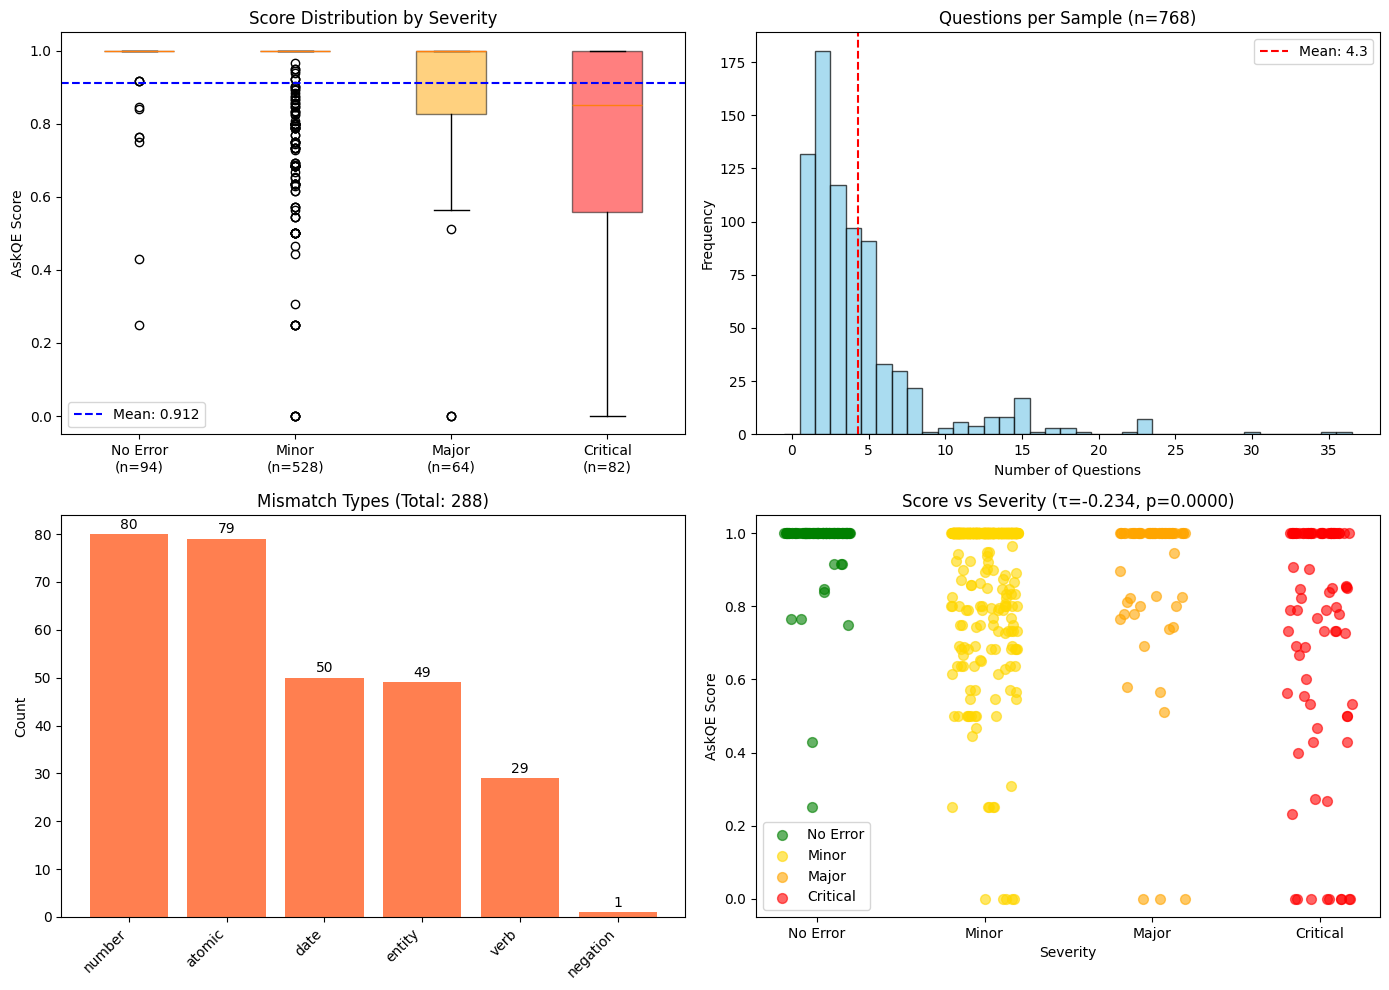


🔍 MISMATCH ANALYSIS BY SEVERITY
type      atomic  date  entity  negation  number  verb
severity                                              
Critical      20    12      20         1      17     4
Major          8     2       7         0      18     2
Minor         47    35      20         0      41    23
No Error       4     1       2         0       4     0

🔎 WORST SCORE SAMPLES

📝 ID: doc63_24 | Severity: Critical | Score: 0.000
   Questions: 2 (Template: 0, Atomic: 2)
   Mismatches: 2
   Source: Our goal is to provide the status of neoadjuvant and adjuvant treatment in MIBC....
   BT: Our aim is to provide the status of neoadjuvant and adjuvant treatment in IBC....

📝 ID: doc63_112 | Severity: Minor | Score: 0.000
   Questions: 2 (Template: 0, Atomic: 2)
   Mismatches: 2
   Source: Our goal is to provide the status of neoadjuvant and adjuvant treatment in MIBC....
   BT: Our goal is to provide the state of neoadjuvant and adjuvant treatment in the CV...

📝 ID: doc86_195 | Severit

In [ ]:
import matplotlib.pyplot as plt

# Use valid data only
df_plot = df_valid.copy()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Score by Severity (Box Plot)
ax1 = axes[0, 0]
severity_groups = []
severity_labels = []
for sev in ["No Error", "Minor", "Major", "Critical"]:
    data = df_plot[df_plot["severity"] == sev]["askqe_score"].dropna()
    if len(data) > 0:
        severity_groups.append(data)
        severity_labels.append(f"{sev}\n(n={len(data)})")

if severity_groups:
    bp = ax1.boxplot(severity_groups, tick_labels=severity_labels, patch_artist=True)
    colors = ['green', 'yellow', 'orange', 'red']
    for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
        patch.set_facecolor(color)
        patch.set_alpha(0.5)

ax1.set_ylabel("AskQE Score")
ax1.set_title("Score Distribution by Severity")
ax1.axhline(y=df_plot["askqe_score"].mean(), color='blue', linestyle='--', label=f'Mean: {df_plot["askqe_score"].mean():.3f}')
ax1.legend()
ax1.set_ylim(-0.05, 1.05)

# 2. Questions Distribution
ax2 = axes[0, 1]
ax2.hist(df_plot["num_questions"], bins=range(0, int(df_plot["num_questions"].max())+2),
         color="skyblue", edgecolor="black", alpha=0.7, align='left')
ax2.axvline(x=df_plot["num_questions"].mean(), color='r', linestyle='--',
            label=f'Mean: {df_plot["num_questions"].mean():.1f}')
ax2.set_xlabel("Number of Questions")
ax2.set_ylabel("Frequency")
ax2.set_title(f"Questions per Sample (n={len(df_plot)})")
ax2.legend()

# 3. Mismatch Types
ax3 = axes[1, 0]
all_mismatches = []
for r in results:
    if r["askqe_score"] is not None:
        for m in r.get("mismatches", []):
            all_mismatches.append(m)

if all_mismatches:
    mismatch_df = pd.DataFrame(all_mismatches)
    mismatch_counts = mismatch_df["type"].value_counts()
    bars = ax3.bar(mismatch_counts.index, mismatch_counts.values, color="coral")
    ax3.set_title(f"Mismatch Types (Total: {len(all_mismatches)})")
    ax3.set_ylabel("Count")
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

    for bar, count in zip(bars, mismatch_counts.values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                str(count), ha='center', va='bottom')
else:
    ax3.text(0.5, 0.5, "No mismatches found", ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title("Mismatch Types")

# 4. Score vs Severity (Scatter with jitter) - FIXED
ax4 = axes[1, 1]
severity_to_num = {"No Error": 0, "Minor": 1, "Major": 2, "Critical": 3}

# FIX: Create numeric severity as a new column properly
df_plot["severity_num"] = df_plot["severity"].astype(str).map(severity_to_num)

# Add jitter
np.random.seed(42)
jitter = np.random.uniform(-0.2, 0.2, len(df_plot))

colors_map = {"No Error": "green", "Minor": "gold", "Major": "orange", "Critical": "red"}
for sev in ["No Error", "Minor", "Major", "Critical"]:
    mask = df_plot["severity"].astype(str) == sev
    if mask.any():
        x_vals = df_plot.loc[mask, "severity_num"].values + jitter[mask.values]
        y_vals = df_plot.loc[mask, "askqe_score"].values
        ax4.scatter(x_vals, y_vals, c=colors_map[sev], label=sev, alpha=0.6, s=50)

ax4.set_xticks([0, 1, 2, 3])
ax4.set_xticklabels(["No Error", "Minor", "Major", "Critical"])
ax4.set_xlabel("Severity")
ax4.set_ylabel("AskQE Score")
ax4.set_title(f"Score vs Severity (τ={tau_sev:.3f}, p={p_tau_sev:.4f})")
ax4.legend(loc='lower left')
ax4.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

# Mismatch analysis by severity
print("\n" + "="*60)
print("🔍 MISMATCH ANALYSIS BY SEVERITY")
print("="*60)

if all_mismatches:
    mismatch_with_sev = []
    for r in results:
        if r["askqe_score"] is not None:
            for m in r.get("mismatches", []):
                m_copy = m.copy()
                m_copy["severity"] = r["severity"]
                mismatch_with_sev.append(m_copy)

    if mismatch_with_sev:
        mismatch_sev_df = pd.DataFrame(mismatch_with_sev)
        print(mismatch_sev_df.groupby(["severity", "type"]).size().unstack(fill_value=0))
else:
    print("No mismatches found")

# Worst samples
print("\n" + "="*60)
print("🔎 WORST SCORE SAMPLES")
print("="*60)

worst = df_valid.nsmallest(5, "askqe_score")
for _, row in worst.iterrows():
    print(f"\n📝 ID: {row['id']} | Severity: {row['severity']} | Score: {row['askqe_score']:.3f}")
    print(f"   Questions: {row['num_questions']} (Template: {row['num_template_qs']}, Atomic: {row['num_atomic_qs']})")
    print(f"   Mismatches: {row['num_mismatches']}")
    print(f"   Source: {row['source'][:80]}...")
    print(f"   BT: {row['backtranslation'][:80]}...")

##Additional Metrics

In [ ]:
from scipy.stats import pearsonr, kendalltau, spearmanr
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

print("="*60)
print("📊 COMPREHENSIVE METRICS ANALYSIS")
print("="*60)

# Use valid data
df_metrics = df_valid.copy()

# Create numeric severity
severity_to_num = {"No Error": 0, "Minor": 1, "Major": 2, "Critical": 3}
df_metrics["severity_num"] = df_metrics["severity"].astype(str).map(severity_to_num)

# Create MQM-style score (higher = better)
mqm_map = {"No Error": 100, "Minor": 99, "Major": 95, "Critical": 75}
df_metrics["mqm_score"] = df_metrics["severity"].astype(str).map(mqm_map)

# ============================================
# 1. ALL CORRELATION METRICS
# ============================================
print("\n" + "-"*60)
print("1️⃣ CORRELATION METRICS")
print("-"*60)

# vs Severity (higher severity = worse)
tau_sev, p_tau = kendalltau(df_metrics["severity_num"], df_metrics["askqe_score"])
rho_sev, p_rho = spearmanr(df_metrics["severity_num"], df_metrics["askqe_score"])
pear_sev, p_pear = pearsonr(df_metrics["severity_num"], df_metrics["askqe_score"])

print(f"\nCorrelation with Severity (expected: NEGATIVE)")
print(f"   Kendall's τ:  {tau_sev:.4f} (p={p_tau:.2e})")
print(f"   Spearman ρ:   {rho_sev:.4f} (p={p_rho:.2e})")
print(f"   Pearson r:    {pear_sev:.4f} (p={p_pear:.2e})")

# vs MQM Score (higher MQM = better quality = higher askqe expected)
tau_mqm, p_tau_m = kendalltau(df_metrics["mqm_score"], df_metrics["askqe_score"])
rho_mqm, p_rho_m = spearmanr(df_metrics["mqm_score"], df_metrics["askqe_score"])
pear_mqm, p_pear_m = pearsonr(df_metrics["mqm_score"], df_metrics["askqe_score"])

print(f"\nCorrelation with MQM Score (expected: POSITIVE)")
print(f"   Kendall's τ:  {tau_mqm:.4f} (p={p_tau_m:.2e})")
print(f"   Spearman ρ:   {rho_mqm:.4f} (p={p_rho_m:.2e})")
print(f"   Pearson r:    {pear_mqm:.4f} (p={p_pear_m:.2e})")

# ============================================
# 2. DECISION ACCURACY (GMM-based, like Paper)
# ============================================
print("\n" + "-"*60)
print("2️⃣ DECISION ACCURACY (GMM-based)")
print("-"*60)

# Ground truth: Accept = No Error/Minor, Reject = Major/Critical
df_metrics["human_decision"] = df_metrics["severity"].astype(str).apply(
    lambda x: 1 if x in ["No Error", "Minor"] else 0  # 1=Accept, 0=Reject
)

# GMM clustering
X = df_metrics["askqe_score"].values.reshape(-1, 1)
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X)
labels = gmm.predict(X)

# Identify Accept cluster (higher mean score)
means = gmm.means_.flatten()
accept_label = np.argmax(means)
df_metrics["predicted_decision"] = (labels == accept_label).astype(int)

# Calculate accuracy
decision_accuracy = accuracy_score(df_metrics["human_decision"], df_metrics["predicted_decision"])
print(f"\nGMM Decision Accuracy: {decision_accuracy*100:.2f}%")

# Confusion matrix
cm = confusion_matrix(df_metrics["human_decision"], df_metrics["predicted_decision"])
print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"                 Reject  Accept")
print(f"   Actual Reject   {cm[0,0]:4d}    {cm[0,1]:4d}")
print(f"   Actual Accept   {cm[1,0]:4d}    {cm[1,1]:4d}")

# ============================================
# 3. BINARY CLASSIFICATION METRICS
# ============================================
print("\n" + "-"*60)
print("3️⃣ BINARY CLASSIFICATION (Error Detection)")
print("-"*60)

# Binary: Has Error (Major/Critical) vs No/Minor Error
df_metrics["has_serious_error"] = df_metrics["severity"].astype(str).apply(
    lambda x: 1 if x in ["Major", "Critical"] else 0
)

# Find optimal threshold
thresholds = np.arange(0.5, 1.0, 0.05)
best_f1 = 0
best_threshold = 0.5

for thresh in thresholds:
    pred = (df_metrics["askqe_score"] < thresh).astype(int)  # Low score = error
    f1 = f1_score(df_metrics["has_serious_error"], pred, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh

print(f"\nOptimal Threshold: {best_threshold:.2f}")
print(f"(Scores below this indicate Major/Critical error)")

# Predictions with optimal threshold
df_metrics["predicted_error"] = (df_metrics["askqe_score"] < best_threshold).astype(int)

precision = precision_score(df_metrics["has_serious_error"], df_metrics["predicted_error"], zero_division=0)
recall = recall_score(df_metrics["has_serious_error"], df_metrics["predicted_error"], zero_division=0)
f1 = f1_score(df_metrics["has_serious_error"], df_metrics["predicted_error"], zero_division=0)

print(f"\nError Detection Performance:")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")

# ROC-AUC (using inverted score since low score = error)
try:
    auc = roc_auc_score(df_metrics["has_serious_error"], 1 - df_metrics["askqe_score"])
    print(f"   ROC-AUC:   {auc:.4f}")
except:
    print(f"   ROC-AUC:   N/A")

# ============================================
# 4. PER-SEVERITY ANALYSIS
# ============================================
print("\n" + "-"*60)
print("4️⃣ PER-SEVERITY DETECTION RATE")
print("-"*60)

for sev in ["No Error", "Minor", "Major", "Critical"]:
    sev_data = df_metrics[df_metrics["severity"].astype(str) == sev]
    if len(sev_data) > 0:
        detected = (sev_data["askqe_score"] < best_threshold).sum()
        total = len(sev_data)
        rate = detected / total * 100
        print(f"   {sev:12s}: {detected:3d}/{total:3d} detected ({rate:5.1f}%)")

# ============================================
# 5. COMPARISON SUMMARY
# ============================================
print("\n" + "="*60)
print("📈 COMPARISON WITH BASELINE")
print("="*60)

print(f"""
┌────────────────────────────────────────────────────────────┐
│                    METRIC COMPARISON                        │
├────────────────────────────────────────────────────────────┤
│ Metric              │ Baseline │ Ours     │ Improvement    │
├────────────────────────────────────────────────────────────┤
│ Kendall τ (vs MQM)  │  0.109   │  {abs(tau_mqm):.3f}    │  {(abs(tau_mqm)/0.109-1)*100:+.0f}%           │
│ Spearman ρ (vs MQM) │  ~0.12   │  {abs(rho_mqm):.3f}    │  {(abs(rho_mqm)/0.12-1)*100:+.0f}%           │
│ Decision Accuracy   │  ~50%    │  {decision_accuracy*100:.1f}%   │  {(decision_accuracy-0.5)*100:+.0f}pp          │
│ Error Detection F1  │   N/A    │  {f1:.3f}    │    N/A         │
└────────────────────────────────────────────────────────────┘
""")

📊 COMPREHENSIVE METRICS ANALYSIS

------------------------------------------------------------
1️⃣ CORRELATION METRICS
------------------------------------------------------------

Correlation with Severity (expected: NEGATIVE)
   Kendall's τ:  -0.2345 (p=4.37e-13)
   Spearman ρ:   -0.2609 (p=2.04e-13)
   Pearson r:    -0.2982 (p=3.08e-17)

Correlation with MQM Score (expected: POSITIVE)
   Kendall's τ:  0.2345 (p=4.37e-13)
   Spearman ρ:   0.2609 (p=2.04e-13)
   Pearson r:    0.3090 (p=1.88e-18)

------------------------------------------------------------
2️⃣ DECISION ACCURACY (GMM-based)
------------------------------------------------------------

GMM Decision Accuracy: 73.70%

Confusion Matrix:
                 Predicted
                 Reject  Accept
   Actual Reject     66      80
   Actual Accept    122     500

------------------------------------------------------------
3️⃣ BINARY CLASSIFICATION (Error Detection)
------------------------------------------------------------



##Save Results

In [ ]:
# Save to JSON
output_file = "extension_results.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)
print(f"✅ Results saved to {output_file}")

# Save summary to CSV
summary_df = df[["row_id", "id", "severity", "mqm_score", "num_questions", "num_mismatches", "askqe_score"]]
summary_df.to_csv("extension_summary.csv", index=False)
print(f"✅ Summary saved to extension_summary.csv")

# Final Summary
print("\n" + "="*60)
print("📋 FINAL SUMMARY")
print("="*60)
print(f"""
Extension Pipeline Results:
- Total Samples: {len(df)}
- Mean AskQE Score: {df['askqe_score'].mean():.3f}
- Samples with Errors Detected: {len(errors_df)} ({100*len(errors_df)/len(df):.1f}%)
- Avg Questions/Sample: {df['num_questions'].mean():.1f}
- Correlation (Kendall Tau): {tau:.4f}

Top Mismatch Types:
{mismatch_df['type'].value_counts().head(3).to_string() if all_mismatches else 'None'}
""")